In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                            roc_curve, recall_score, classification_report, f1_score)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter


In [2]:
# 设置随机种子以确保可复现性
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True

In [3]:
# 设置可视化参数
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8

LABELS = ["Normal", "Fraud"]

In [4]:
# 检查是否有GPU可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [5]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=32):
        super(Autoencoder, self).__init__()
        
        # 编码器 - 增加层数和非线性变换
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim * 4),
            nn.ReLU(),
            nn.BatchNorm1d(encoding_dim * 4),  # 添加批量归一化提高稳定性
            nn.Dropout(0.5),  # 添加Dropout防止过拟合
            
            nn.Linear(encoding_dim * 4, encoding_dim * 2),
            nn.ReLU(),
            nn.BatchNorm1d(encoding_dim * 2),
            
            nn.Linear(encoding_dim * 2, encoding_dim),
            nn.ReLU(),
            nn.BatchNorm1d(encoding_dim),
            
            nn.Linear(encoding_dim, encoding_dim // 2),
            nn.ReLU(),
            
            # 进一步压缩表示
            nn.Linear(encoding_dim // 2, encoding_dim // 4),
            nn.ReLU()
        )
        
        # 解码器 - 对称结构
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim // 4, encoding_dim // 2),
            nn.ReLU(),
            nn.BatchNorm1d(encoding_dim // 2),
            
            nn.Linear(encoding_dim // 2, encoding_dim),
            nn.ReLU(),
            nn.BatchNorm1d(encoding_dim),
            
            nn.Linear(encoding_dim, encoding_dim * 2),
            nn.ReLU(),
            nn.BatchNorm1d(encoding_dim * 2),
            nn.Dropout(0.2),
            
            nn.Linear(encoding_dim * 2, encoding_dim * 4),
            nn.ReLU(),
            nn.BatchNorm1d(encoding_dim * 4),
            
            nn.Linear(encoding_dim * 4, input_dim),
            nn.Sigmoid()  # 如果输入数据是归一化到[0,1]范围，使用Sigmoid更合适
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def add_l1_regularization(self, loss, lambda_l1=1e-5):
        l1_reg = torch.tensor(0., requires_grad=True).to(device)
        for param in self.encoder[0].parameters():
            l1_reg = l1_reg + torch.sum(torch.abs(param))
        return loss + lambda_l1 * l1_reg

In [6]:
class SimpleConvAutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=32):
        super(SimpleConvAutoEncoder, self).__init__()
        
        # 通道设置
        self.conv_channels = 8
        
        # 编码器
        self.encoder_linear = nn.Linear(input_dim, encoding_dim * 4)
        self.encoder_relu = nn.ReLU()
        self.encoder_conv = nn.Conv1d(self.conv_channels, self.conv_channels, kernel_size=3, padding=1)
        self.encoder_pool = nn.MaxPool1d(2)
        self.encoder_linear2 = nn.Linear((encoding_dim * 4 // self.conv_channels) // 2 * self.conv_channels, encoding_dim // 2)
        
        # 解码器
        self.decoder_linear = nn.Linear(encoding_dim // 2, (encoding_dim * 4 // self.conv_channels) // 2 * self.conv_channels)
        self.decoder_upsample = nn.Upsample(scale_factor=2)
        self.decoder_conv = nn.ConvTranspose1d(self.conv_channels, self.conv_channels, kernel_size=3, padding=1)
        self.decoder_linear2 = nn.Linear(encoding_dim * 4, input_dim)
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # 编码
        x = self.encoder_linear(x)
        x = self.encoder_relu(x)
        
        # reshape为卷积输入 [batch, channels, seq_len]
        seq_len = x.size(1) // self.conv_channels
        x = x.view(batch_size, self.conv_channels, seq_len)
        
        x = self.encoder_conv(x)
        x = self.encoder_pool(x)
        
        # 扁平化
        x = x.view(batch_size, -1)
        encoded = self.encoder_linear2(x)
        
        # 解码
        x = self.decoder_linear(encoded)
        
        # reshape为卷积输入
        x = x.view(batch_size, self.conv_channels, -1)
        
        x = self.decoder_upsample(x)
        x = self.decoder_conv(x)
        
        # 扁平化
        x = x.view(batch_size, -1)
        decoded = self.decoder_linear2(x)
        
        return decoded
    
    def add_l1_regularization(self, loss, lambda_l1=1e-5):
        l1_reg = torch.tensor(0., requires_grad=True).to(device)
        for param in self.encoder_linear.parameters():
            l1_reg = l1_reg + torch.sum(torch.abs(param))
        return loss + lambda_l1 * l1_reg

In [7]:
class ConvAutoEncoderDeeper(nn.Module):
    def __init__(self, input_dim, encoding_dim=32):
        super(ConvAutoEncoderDeeper, self).__init__()
        
        # 通道设置
        self.conv_channels = 8
         # 计算最终的特征维度
        seq_len_after_pool = (encoding_dim * 4 // self.conv_channels) // 2
        
        # 编码器 - 线性部分
        self.encoder_linear = nn.Linear(input_dim, encoding_dim * 4)
        self.encoder_relu = nn.ReLU()
        
        # 编码器 - 卷积部分
        self.encoder_conv = nn.Sequential(
                                     nn.Conv1d(self.conv_channels, self.conv_channels, kernel_size=3, padding=1),
                                     nn.ReLU(),
                                     nn.Conv1d(self.conv_channels, self.conv_channels, kernel_size=3, padding=1),
                                     nn.ReLU(),
                                     nn.Conv1d(self.conv_channels, self.conv_channels, kernel_size=3, padding=1),
                                     nn.ReLU(),
                                     nn.Conv1d(self.conv_channels, self.conv_channels, kernel_size=3, padding=1),
                                     nn.ReLU(),
                                     nn.Conv1d(self.conv_channels, self.conv_channels, kernel_size=3, padding=1),
                                     nn.ReLU(),
                                     nn.MaxPool1d(2),
                                     
                                     )
        # 压缩部分
        self.encoder_linear2 = nn.Linear(seq_len_after_pool * self.conv_channels, encoding_dim // 2)
        
        # 解码器 - 扩展部分
        self.decoder_linear = nn.Linear(encoding_dim // 2, seq_len_after_pool * self.conv_channels)
        
        # 解码器 - 反卷积部分
        self.decoder_conv = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(self.conv_channels, self.conv_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(self.conv_channels, self.conv_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(self.conv_channels, self.conv_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(self.conv_channels, self.conv_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(self.conv_channels, self.conv_channels, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        # 解码器 - 输出部分
        self.decoder_linear2 = nn.Linear(encoding_dim * 4, input_dim)
        
    def forward(self, x):
        batch_size = x.size(0)
    
        # 编码器 - 线性部分
        x = self.encoder_linear(x)
        x = self.encoder_relu(x)
    
        # 重塑为卷积输入格式 [batch, channels, seq_len]
        seq_len = x.size(1) // self.conv_channels
        x = x.view(batch_size, self.conv_channels, seq_len)
    
        # 编码器 - 卷积部分 (多层卷积)
        x = self.encoder_conv(x)
    
        # 扁平化
        x = x.view(batch_size, -1)
    
        # 编码器 - 压缩部分
        encoded = self.encoder_linear2(x)  # 修正为 encoder_linear2
    
        # 解码器 - 扩展部分
        x = self.decoder_linear(encoded)
    
        # 重塑为卷积输入格式
        x = x.view(batch_size, self.conv_channels, -1)
    
        # 解码器 - 卷积部分 (多层卷积)
        x = self.decoder_conv(x)

        # 扁平化
        x = x.view(batch_size, -1)
    
        # 解码器 - 输出部分
        decoded = self.decoder_linear2(x)
    
        return decoded
    
    def add_l1_regularization(self, loss, lambda_l1=1e-5):
        l1_reg = torch.tensor(0., requires_grad=True).to(device)
        for param in self.encoder_linear.parameters():
            l1_reg = l1_reg + torch.sum(torch.abs(param))
        return loss + lambda_l1 * l1_reg

检查ConvAutoEncoderDeeper

In [8]:
X = torch.rand(64,30,dtype=torch.float32).cuda()


In [9]:
# 数据加载和预处理函数
def load_and_preprocess_data(file_path):
    """加载并预处理数据"""
    df = pd.read_csv(file_path)
    print(f"数据集形状: {df.shape}")
    
    # 检查缺失值
    print(f"是否存在缺失值: {df.isnull().values.any()}")
    
    # 查看类别分布
    count_classes = pd.value_counts(df['Class'], sort=True)
    print("Class distribution:")
    print(count_classes)
    
    # 创建欺诈和正常交易数据框
    frauds = df[df.Class == 1]
    normal = df[df.Class == 0]
    print(f"欺诈交易数量: {frauds.shape[0]}")
    print(f"正常交易数量: {normal.shape[0]}")
    
    # 移除Time列并标准化Amount
    data = df.drop(['Time'], axis=1)
    data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
    
    return data

In [10]:
# 划分训练集和测试集
def prepare_datasets(data):
    """准备训练集和测试集"""
    X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
    X_train = X_train[X_train.Class == 0]  # 只使用正常交易进行训练
    X_train = X_train.drop(['Class'], axis=1)
    
    y_test = X_test['Class']  # 保存测试集标签
    X_test = X_test.drop(['Class'], axis=1)
    
    # 转换为NumPy数组
    X_train = X_train.values
    X_test = X_test.values
    
    # 转换为PyTorch张量
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    y_test_tensor = torch.FloatTensor(y_test.values).to(device)
    
    # 创建数据加载器
    train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, X_test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    return train_loader, test_loader, X_test, y_test, X_train.shape[1]

# 使用AE训练

In [11]:
# 训练模型AE
def train_model(model, train_loader, test_loader, num_epochs=50):
    """训练自编码器模型"""
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())
    writer = SummaryWriter('./logs/pytorch_autoencoder')
    
    best_test_loss = float('inf')
    history = {'train_loss': [], 'test_loss': []}
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        train_loss = 0
        for batch_features, _ in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_features)
            # 添加L1正则化
            loss = model.add_l1_regularization(loss)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss = train_loss / len(train_loader)
        history['train_loss'].append(train_loss)
        
        # 验证阶段
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for batch_features, _ in test_loader:
                outputs = model(batch_features)
                loss = criterion(outputs, batch_features)
                test_loss += loss.item()
        
        test_loss = test_loss / len(test_loader)
        history['test_loss'].append(test_loss)
        
        # 记录到TensorBoard
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Loss/test', test_loss, epoch)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
        
        # 保存最佳模型
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            torch.save(model.state_dict(), 'AEConv/best_autoencoder.pth')
            print("Model saved!")
    
    writer.close()
    return history


In [12]:
# 计算重构误差
def calculate_reconstruction_error(model, X_test_tensor):
    """计算测试集的重构误差"""
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor)
        mse = nn.MSELoss(reduction='none')(predictions, X_test_tensor)
        mse = mse.mean(dim=1).cpu().numpy()
    return mse

In [13]:
# 评估模型
def evaluate_model(model, X_test, y_test):
    """评估模型性能"""
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    
    # 计算重构误差
    # calculate_reconstruction_error
    # calculate_reconstruction_error_vae
    mse = calculate_reconstruction_error(model, X_test_tensor)
    
    # 创建重构误差数据框
    error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test})
    
    # 绘制ROC曲线
    fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.001, 1])
    plt.ylim([0, 1.001])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.savefig('roc_curve.png')
    plt.show()
    
    # 绘制精确度-召回率曲线
    precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
    plt.figure(figsize=(10, 8))
    plt.plot(recall, precision, 'b', label='Precision-Recall curve')
    plt.title('Recall vs Precision')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.savefig('precision_recall_curve.png')
    plt.show()
    
    # 确定最佳阈值（可以根据具体需求调整）
    threshold = 0.5  # 可以通过分析精确度-召回率曲线优化
    
    # 使用阈值进行预测
    y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
    conf_matrix = confusion_matrix(error_df.true_class, y_pred)
    
    # 绘制混淆矩阵
    plt.figure(figsize=(12, 12))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    # 打印分类报告
    print(classification_report(error_df.true_class, y_pred))
    
    return error_df, threshold

In [14]:
# 可视化重构误差
def visualize_reconstruction_error(error_df, threshold):
    """可视化不同类别的重构误差"""
    plt.figure(figsize=(14, 10))
    
    # 正常交易的重构误差直方图
    plt.subplot(2, 1, 1)
    normal_error_df = error_df[(error_df['true_class'] == 0) & (error_df['reconstruction_error'] < 10)]
    plt.hist(normal_error_df.reconstruction_error.values, bins=10)
    plt.title("Reconstruction error: Normal transactions")
    plt.ylabel("Count")
    
    # 欺诈交易的重构误差直方图
    plt.subplot(2, 1, 2)
    fraud_error_df = error_df[error_df['true_class'] == 1]
    plt.hist(fraud_error_df.reconstruction_error.values, bins=10)
    plt.title("Reconstruction error: Fraudulent transactions")
    plt.ylabel("Count")
    plt.xlabel("Reconstruction error")
    
    plt.tight_layout()
    plt.savefig('reconstruction_error_histograms.png')
    plt.show()
    
    # 所有数据点的重构误差散点图
    plt.figure(figsize=(14, 10))
    groups = error_df.groupby('true_class')
    
    for name, group in groups:
        plt.scatter(group.index, group.reconstruction_error, 
                  marker='o', s=3.5, 
                  label="Fraud" if name == 1 else "Normal")
    
    plt.axhline(y=threshold, color='r', linestyle='-', label='Threshold')
    plt.legend()
    plt.title("Reconstruction error for different classes")
    plt.ylabel("Reconstruction error")
    plt.xlabel("Data point index")
    plt.savefig('reconstruction_error_scatter.png')
    plt.show()


In [15]:
# 主函数
def main(file_path):
    """主函数"""
    print("加载和预处理数据...")
    data = load_and_preprocess_data(file_path)
    
    print("准备数据集...")
    train_loader, test_loader, X_test, y_test, input_dim = prepare_datasets(data)
    
    print("构建和训练模型...")
    
    model = Autoencoder(input_dim=input_dim).to(device)
    history = train_model(model, train_loader, test_loader)
    
    # 加载最佳模型
    model.load_state_dict(torch.load('best_autoencoder.pth'))
    
    # 绘制损失曲线
    plt.figure(figsize=(14, 8))
    plt.plot(history['train_loss'], label='Train loss')
    plt.plot(history['test_loss'], label='Test loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.savefig('loss_curve.png') 
    plt.show()
    
    print("评估模型...")
    error_df, threshold = evaluate_model(model, X_test, y_test)
    
    print("可视化重构误差...")
    visualize_reconstruction_error(error_df, threshold)
    
    print("完成!")
    return model, error_df, threshold

加载和预处理数据...
数据集形状: (284807, 31)
是否存在缺失值: False
Class distribution:
0    284315
1       492
Name: Class, dtype: int64
欺诈交易数量: 492
正常交易数量: 284315
准备数据集...
构建和训练模型...
Epoch 1/50, Train Loss: 0.8791, Test Loss: 0.8317
Model saved!
Epoch 2/50, Train Loss: 0.8185, Test Loss: 0.8133
Model saved!
Epoch 3/50, Train Loss: 0.8067, Test Loss: 0.8065
Model saved!
Epoch 4/50, Train Loss: 0.7997, Test Loss: 0.8016
Model saved!
Epoch 5/50, Train Loss: 0.7929, Test Loss: 0.7941
Model saved!
Epoch 6/50, Train Loss: 0.7880, Test Loss: 0.7906
Model saved!
Epoch 7/50, Train Loss: 0.7851, Test Loss: 0.7891
Model saved!
Epoch 8/50, Train Loss: 0.7829, Test Loss: 0.7869
Model saved!
Epoch 9/50, Train Loss: 0.7810, Test Loss: 0.7848
Model saved!
Epoch 10/50, Train Loss: 0.7797, Test Loss: 0.7844
Model saved!
Epoch 11/50, Train Loss: 0.7785, Test Loss: 0.7836
Model saved!
Epoch 12/50, Train Loss: 0.7774, Test Loss: 0.7833
Model saved!
Epoch 13/50, Train Loss: 0.7769, Test Loss: 0.7822
Model saved!
Epoch 14/50, 

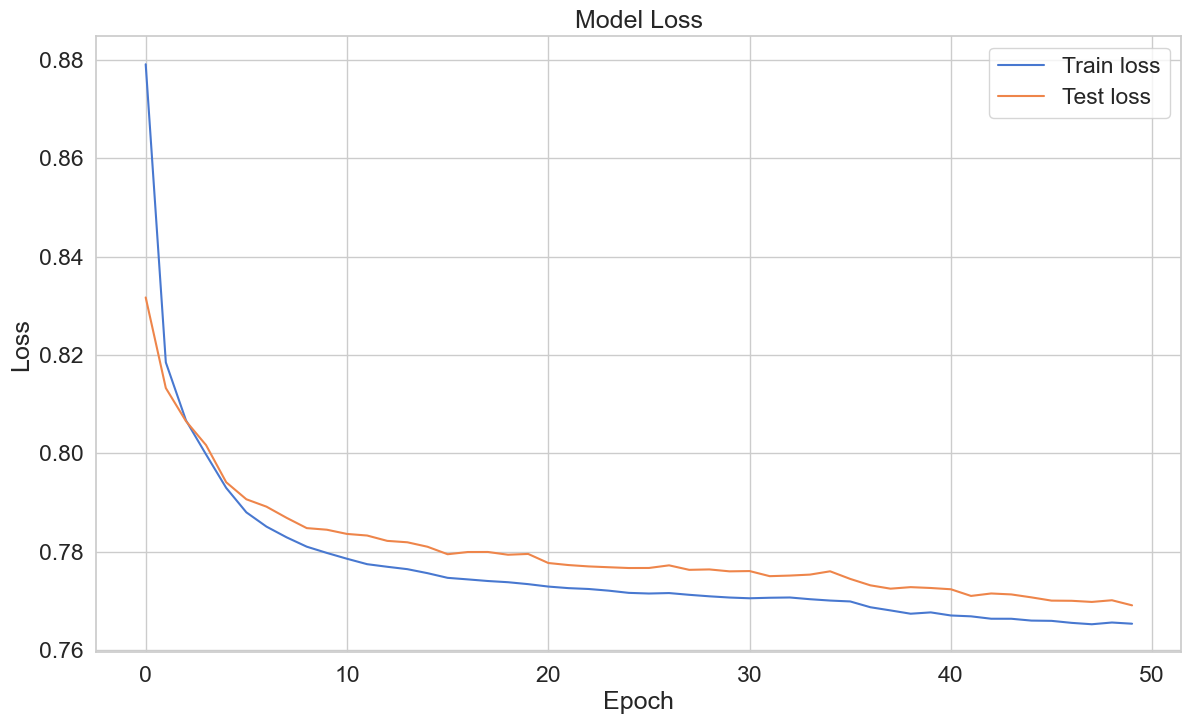

评估模型...


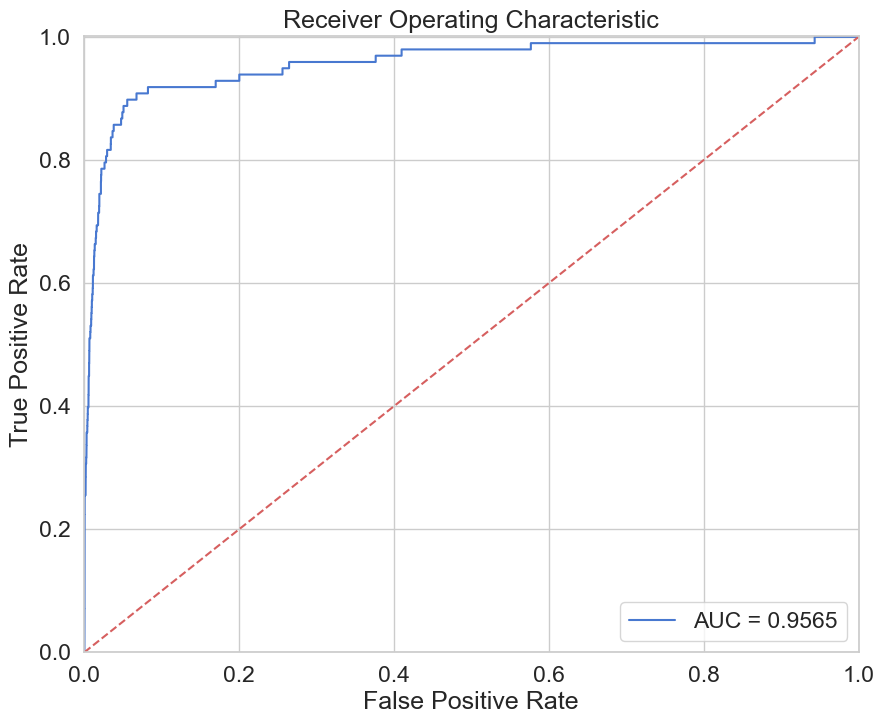

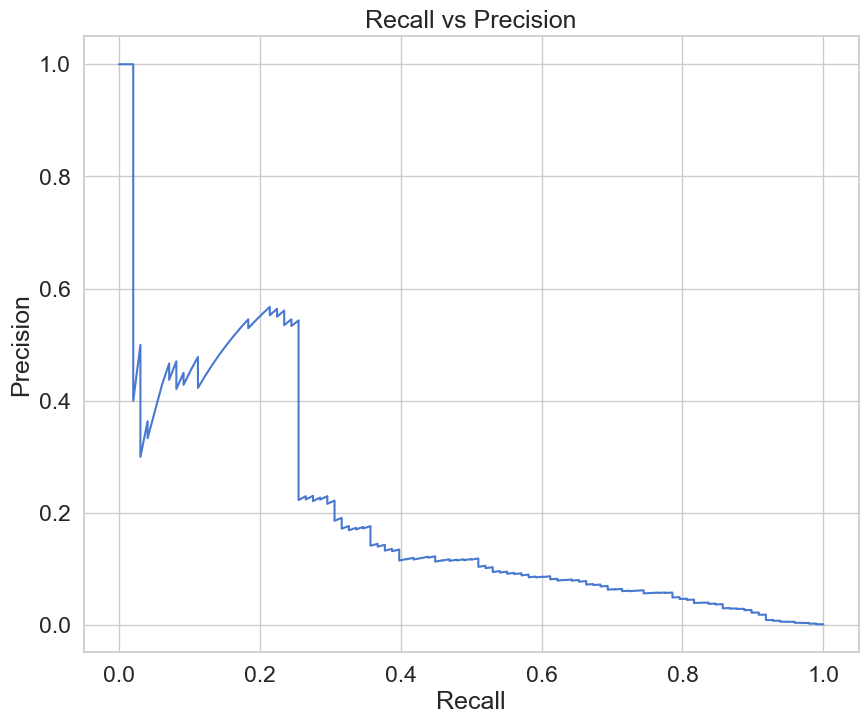

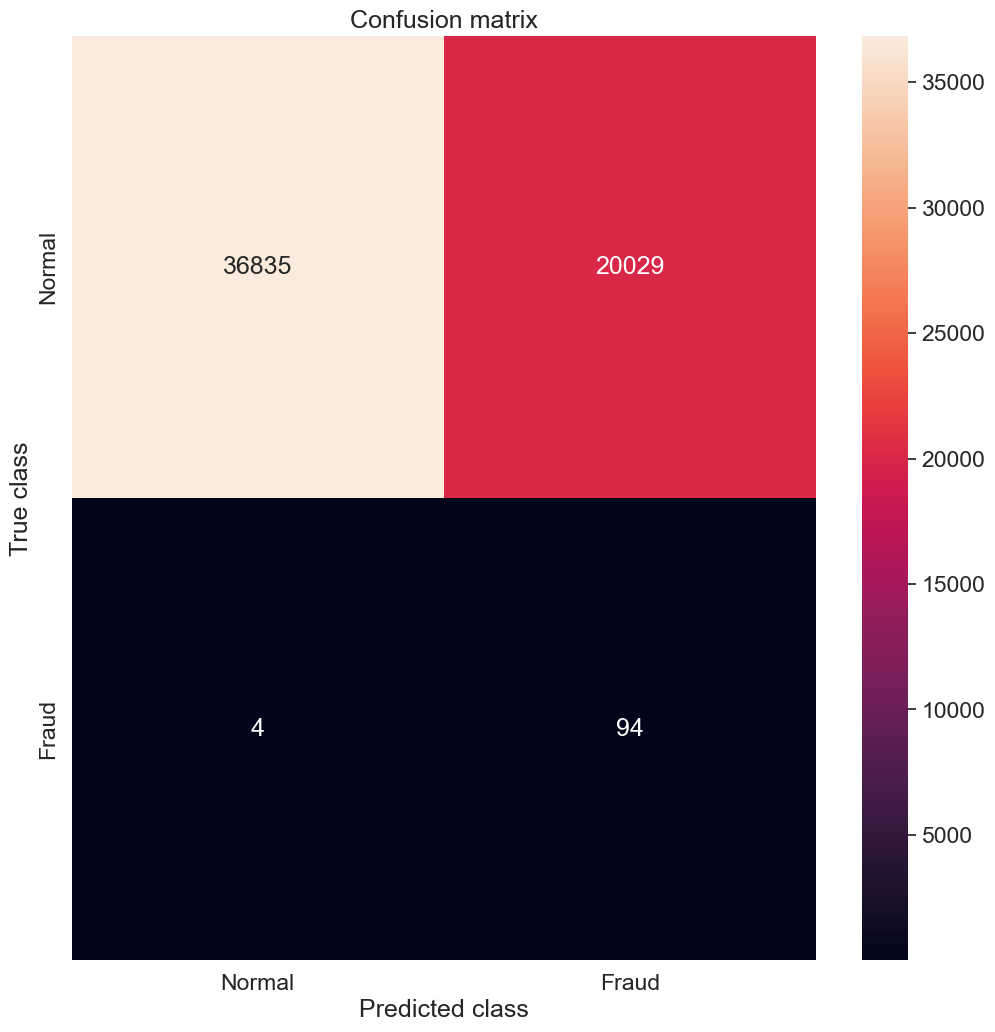

              precision    recall  f1-score   support

           0       1.00      0.65      0.79     56864
           1       0.00      0.96      0.01        98

    accuracy                           0.65     56962
   macro avg       0.50      0.80      0.40     56962
weighted avg       1.00      0.65      0.78     56962

可视化重构误差...


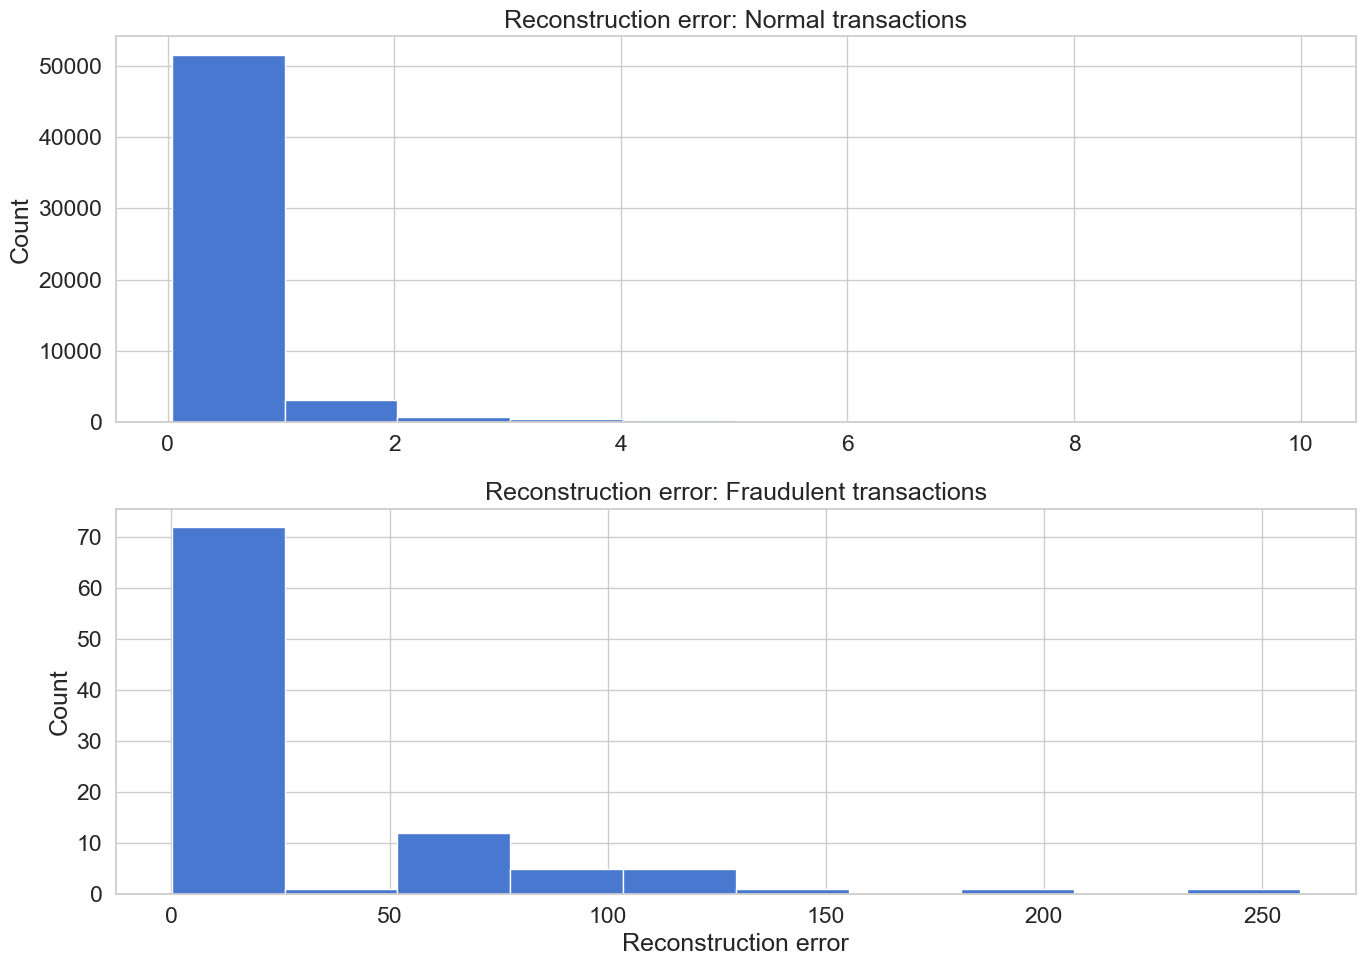

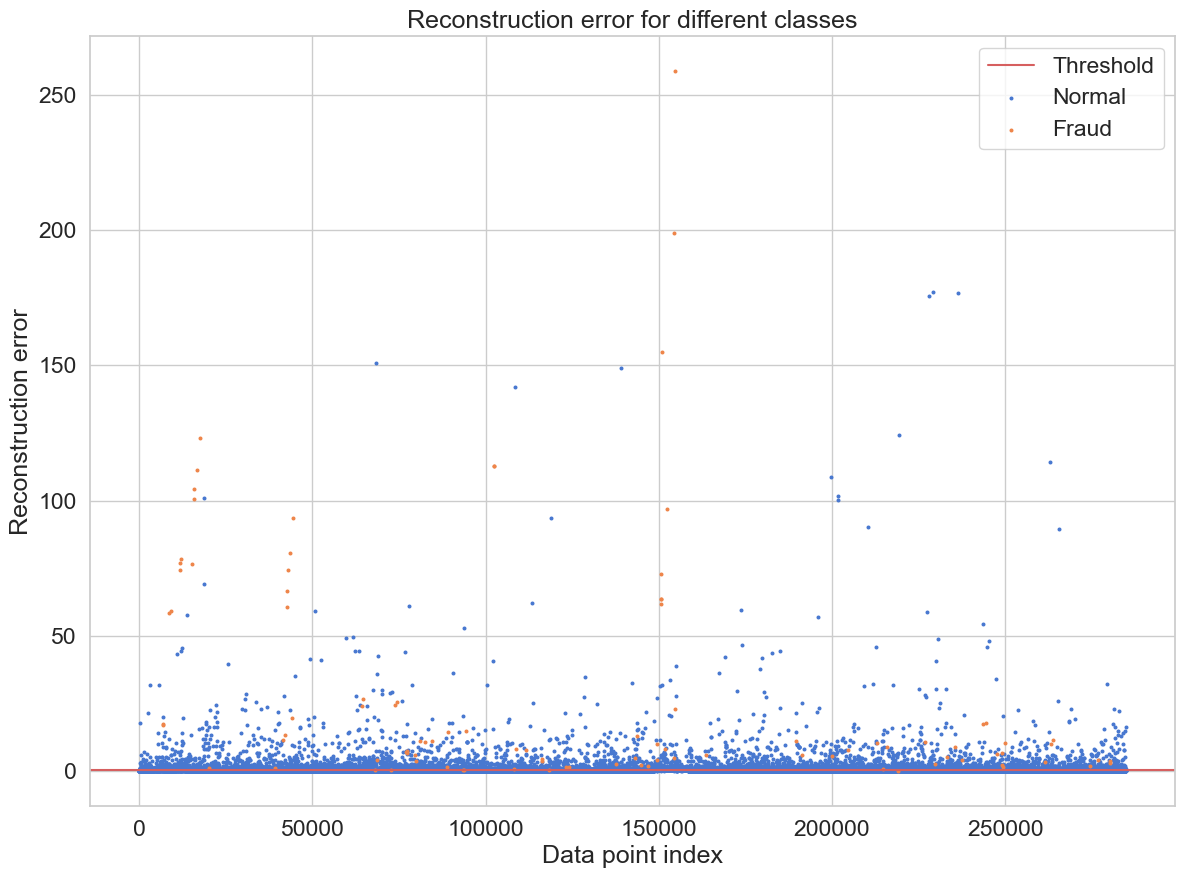

完成!


In [16]:
if __name__ == "__main__":
    file_path = "data/creditcard.csv"  # 数据文件路径
    model, error_df, threshold = main(file_path)